In [1]:
import os
import pandas as pd

df_1_step = pd.DataFrame()
df_5_steps = pd.DataFrame()
df_20_steps = pd.DataFrame()

datasets = sorted([int(x) for x in set(os.listdir('hyperparameter_optimization_output/1 steps ahead')).intersection(set(os.listdir('hyperparameter_optimization_output/5 steps ahead'))).intersection(set(os.listdir('hyperparameter_optimization_output/20 steps ahead')))])
for data_index in datasets:
    df_ = pd.read_csv(f'hyperparameter_optimization_output/1 steps ahead/{data_index}/opt_hist.csv')
    df_['data_set_index'] = data_index
    print(data_index, df_.shape[0])
    if df_.shape[0] > 100:
        df_ = df_.iloc[:100]
        df_.to_csv(f'hyperparameter_optimization_output/1 steps ahead/{data_index}/opt_hist.csv', index=False)
    if df_.shape[0] == 100:
        df_1_step = pd.concat([df_1_step, df_], ignore_index=True, axis=0)
    df_ = pd.read_csv(f'hyperparameter_optimization_output/5 steps ahead/{data_index}/opt_hist.csv')
    df_['data_set_index'] = data_index
    print(data_index, df_.shape[0])
    if df_.shape[0] > 100:
        df_ = df_.iloc[:100]
        df_.to_csv(f'hyperparameter_optimization_output/5 steps ahead/{data_index}/opt_hist.csv', index=False)
    if df_.shape[0] == 100 and data_index in df_1_step['data_set_index'].values:
        df_5_steps = pd.concat([df_5_steps, df_], ignore_index=True, axis=0)
    elif data_index in df_1_step['data_set_index'].values:
        df_1_step = df_1_step[df_1_step['data_set_index'] != data_index]
        break
    else:
        break
    df_ = pd.read_csv(f'hyperparameter_optimization_output/20 steps ahead/{data_index}/opt_hist.csv')
    df_['data_set_index'] = data_index
    print(data_index, df_.shape[0])
    if df_.shape[0] > 100:
        df_ = df_.iloc[:100]
        df_.to_csv(f'hyperparameter_optimization_output/20 steps ahead/{data_index}/opt_hist.csv', index=False)
    if df_.shape[0] == 100 and data_index in df_5_steps['data_set_index'].values:
        df_20_steps = pd.concat([df_20_steps, df_], ignore_index=True, axis=0)
    else:
        if data_index in df_5_steps['data_set_index'].values:
            df_5_steps = df_5_steps[df_5_steps['data_set_index'] != data_index]
        if data_index in df_1_step['data_set_index'].values:
            df_1_step = df_1_step[df_1_step['data_set_index'] != data_index]
        break
datasets = list(df_1_step['data_set_index'].values)

0 100
0 100
0 100
1 100
1 100
1 100
2 100
2 100
2 100
3 100
3 100
3 100
4 100
4 100
4 100
5 100
5 100
5 100
6 100
6 100
6 100
7 100
7 100
7 100
8 100
8 100
8 100
9 100
9 100
9 100
10 100
10 100
10 100
11 100
11 100
11 100
12 100
12 100
12 100
13 100
13 100
13 100
14 100
14 100
14 100
15 100
15 100
15 100
16 100
16 100
16 100
17 100
17 100
17 100
18 100
18 100
18 100
19 100
19 100
19 100
20 100
20 100
20 100
21 100
21 100
21 100
22 100
22 100
22 100
23 100
23 100
23 100
24 100
24 100
24 100
25 100
25 100
25 100
26 100
26 100
26 100
27 100
27 100
27 100
28 100
28 100
28 100
29 100
29 100
29 100
30 100
30 100
30 100
31 100
31 100
31 100
32 100
32 100
32 100
33 100
33 100
33 100
34 100
34 100
34 100
35 100
35 100
35 100
36 100
36 100
36 100
37 100
37 100
37 100
38 100
38 100
38 100
39 100
39 100
39 100
40 100
40 100
40 100
41 100
41 100
41 100
42 100
42 100
42 100
43 100
43 100
43 100
44 100
44 100
44 100
45 100
45 100
45 100
46 100
46 100
46 100
47 100
47 100
47 100
48 100
48 100
48 100
4

In [2]:
datasets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [3]:
df_1_step

,win_size,filters_conv_1,kernel_size_conv_1[0],kernel_size_conv_1[1],activation_conv_1,pool_size_1[0],pool_type_1,filters_conv_2,kernel_size_conv_2[0],activation_conv_2,dense_neurons,optimizer,loss,w2,w3,w4,h4,score,data_set_index
0,735,34,236,5,elu,245,average,9,1,swish,14,adadelta,mean_squared_error,500,2,2,1,0.961213,0
1,143,16,43,2,relu,48,max,7,1,relu,23,adam,mean_squared_logarithmic_error,101,2,2,4,0.608639,0
2,309,21,67,3,relu,67,max,10,2,swish,14,rmsprop,mean_squared_error,243,3,2,3,0.743713,0
3,176,33,46,5,relu,10,max,9,3,relu,84,adagrad,mean_absolute_error,131,13,11,1,0.946446,0
4,800,29,239,5,sigmoid,97,average,9,2,sigmoid,6,adagrad,mean_absolute_error,562,5,4,1,0.803041,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,573,25,166,2,elu,77,max,12,3,tanh,104,rmsprop,mean_absolute_percentage_error,408,5,3,4,0.709792,59
5996,637,27,171,2,elu,104,max,13,3,tanh,88,rmsprop,mean_absolute_percentage_error,467,4,2,4,0.463536,59
5997,641,30,177,2,elu,105,max,14,3,tanh,75,rmsprop,mean_absolute_percentage_error,465,4,2,4,0.584122,59
5998,611,24,172,2,elu,100,max,12,3,tanh,84,rmsprop,mean_absolute_percentage_error,440,4,2,4,0.603023,59


In [4]:
df_1_step_encoded = df_1_step[[c for c in df_1_step.columns if c!='data_set_index']].apply(lambda col: col.map(lambda x: list(col.values).index(x)) if col.dtype == 'object' else col, axis=0)

In [5]:
df_1_step_encoded

,win_size,filters_conv_1,kernel_size_conv_1[0],kernel_size_conv_1[1],activation_conv_1,pool_size_1[0],pool_type_1,filters_conv_2,kernel_size_conv_2[0],activation_conv_2,dense_neurons,optimizer,loss,w2,w3,w4,h4,score
0,735,34,236,5,0,245,0,9,1,0,14,0,0,500,2,2,1,0.961213
1,143,16,43,2,1,48,1,7,1,1,23,1,1,101,2,2,4,0.608639
2,309,21,67,3,1,67,1,10,2,0,14,2,0,243,3,2,3,0.743713
3,176,33,46,5,1,10,1,9,3,1,84,3,3,131,13,11,1,0.946446
4,800,29,239,5,4,97,0,9,2,4,6,3,3,562,5,4,1,0.803041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,573,25,166,2,0,77,1,12,3,6,104,2,5,408,5,3,4,0.709792
5996,637,27,171,2,0,104,1,13,3,6,88,2,5,467,4,2,4,0.463536
5997,641,30,177,2,0,105,1,14,3,6,75,2,5,465,4,2,4,0.584122
5998,611,24,172,2,0,100,1,12,3,6,84,2,5,440,4,2,4,0.603023


Text(0.5, 1.0, 'Pearson Correlation to Score')

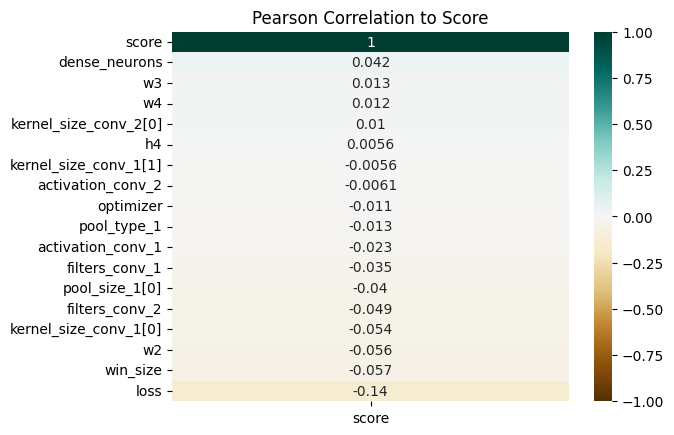

In [6]:
import seaborn as sns
heatmap = sns.heatmap(df_1_step_encoded.corr(method='pearson')[['score']].sort_values(by='score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Pearson Correlation to Score')

Text(0.5, 1.0, 'Kendall Correlation to Score')

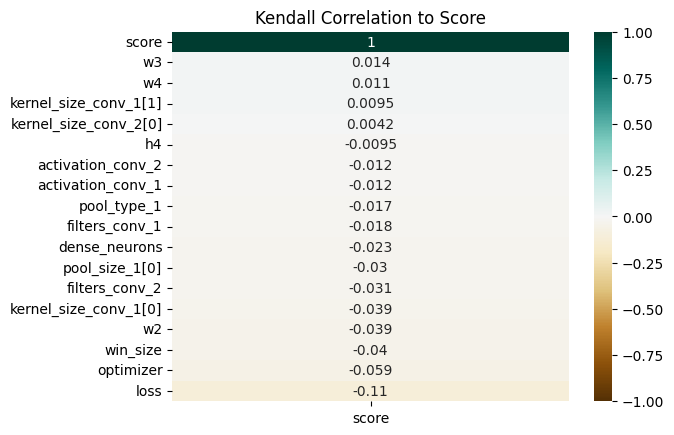

In [7]:
heatmap = sns.heatmap(df_1_step_encoded.corr(method='kendall')[['score']].sort_values(by='score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Kendall Correlation to Score')

Text(0.5, 1.0, 'Spearman Correlation to Score')

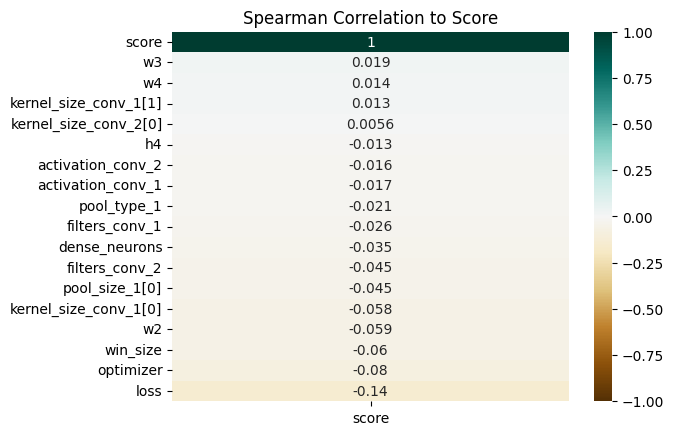

In [8]:
heatmap = sns.heatmap(df_1_step_encoded.corr(method='spearman')[['score']].sort_values(by='score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Spearman Correlation to Score')

Text(0.5, 1.0, 'KS Correlation to Score')

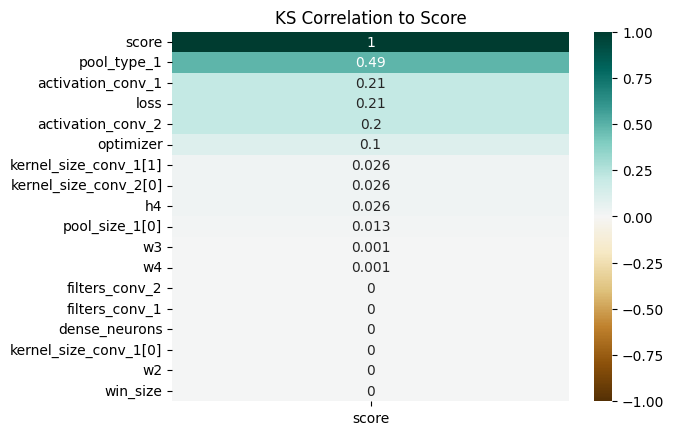

In [9]:
from scipy.stats import ks_2samp
heatmap = sns.heatmap(df_1_step_encoded.corr(method=lambda x, y: 1 - ks_2samp(x, y)[0])[['score']].sort_values(by='score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('KS Correlation to Score')

In [10]:
df_5_steps_encoded = df_5_steps[[c for c in df_5_steps.columns if c!='data_set_index']].apply(lambda col: col.map(lambda x: list(col.values).index(x)) if col.dtype == 'object' else col, axis=0)

Text(0.5, 1.0, 'KS Correlation to Score')

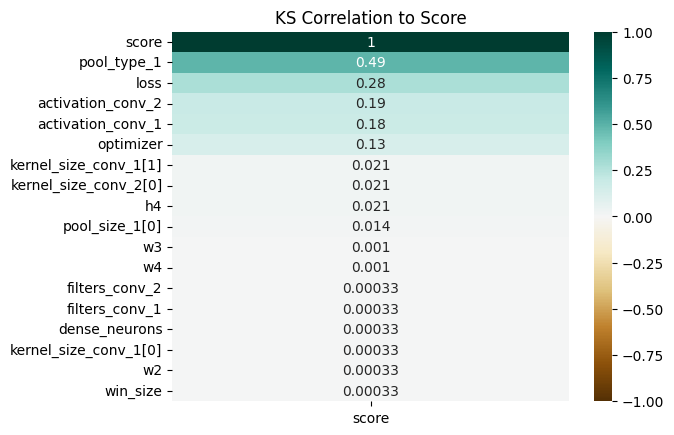

In [11]:
from scipy.stats import ks_2samp
heatmap = sns.heatmap(df_5_steps_encoded.corr(method=lambda x, y: 1 - ks_2samp(x, y)[0])[['score']].sort_values(by='score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('KS Correlation to Score')

In [12]:
df_20_steps_encoded = df_20_steps[[c for c in df_20_steps.columns if c!='data_set_index']].apply(lambda col: col.map(lambda x: list(col.values).index(x)) if col.dtype == 'object' else col, axis=0)

Text(0.5, 1.0, 'KS Correlation to Score')

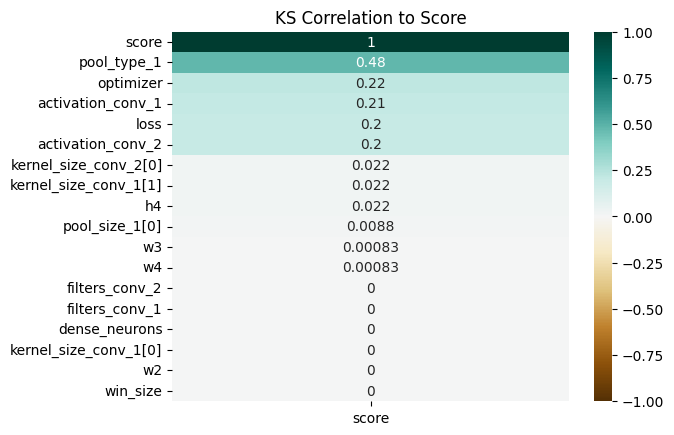

In [13]:
from scipy.stats import ks_2samp
heatmap = sns.heatmap(df_20_steps_encoded.corr(method=lambda x, y: 1 - ks_2samp(x, y)[0])[['score']].sort_values(by='score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('KS Correlation to Score')

In [14]:
df_1_step_optimal = df_1_step.groupby('data_set_index').apply(lambda x: x[x['score'] == x['score'].min()]).reset_index(drop=True)
df_5_steps_optimal = df_5_steps.groupby('data_set_index').apply(lambda x: x[x['score'] == x['score'].min()]).reset_index(drop=True)
df_20_steps_optimal = df_20_steps.groupby('data_set_index').apply(lambda x: x[x['score'] == x['score'].min()]).reset_index(drop=True)

In [15]:
results_var = pd.read_csv('results_summary.csv')
results_var = results_var[results_var['Data_index'].isin(datasets)]

In [16]:
results_var

,Data_index,VAR_result (1 steps ahead),VAR_result (5 steps ahead),VAR_result (20 steps ahead)
0,0,0.013222,0.013564,0.014480
1,1,0.126837,0.154600,0.164536
2,2,0.000475,0.001338,0.004953
3,3,0.006511,0.008404,0.008873
4,4,0.007841,0.007744,0.007674
5,5,0.004179,0.004903,0.009225
6,6,0.003334,0.005987,0.020858
7,7,0.001548,0.002430,0.008521
8,8,0.003140,0.002979,0.003722
9,9,0.002041,0.002537,0.006229


In [17]:
one_step_comparison = []
five_steps_comparison = []
twenty_steps_comparison = []
for data_index in datasets:
    one_step_comparison.append((
        results_var[results_var['Data_index'] == data_index]['VAR_result (1 steps ahead)'].values[0],
        df_1_step_optimal[df_1_step_optimal['data_set_index'] == data_index]['score'].values[0]
    ))
    five_steps_comparison.append((
        results_var[results_var['Data_index'] == data_index]['VAR_result (5 steps ahead)'].values[0],
        df_5_steps_optimal[df_5_steps_optimal['data_set_index'] == data_index]['score'].values[0]
    ))
    twenty_steps_comparison.append((
        results_var[results_var['Data_index'] == data_index]['VAR_result (20 steps ahead)'].values[0],
        df_20_steps_optimal[df_20_steps_optimal['data_set_index'] == data_index]['score'].values[0]
    ))

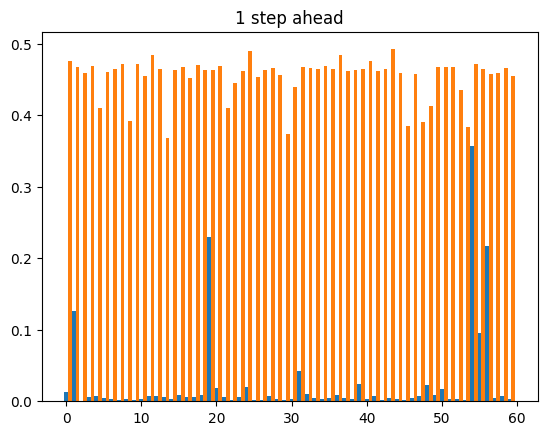

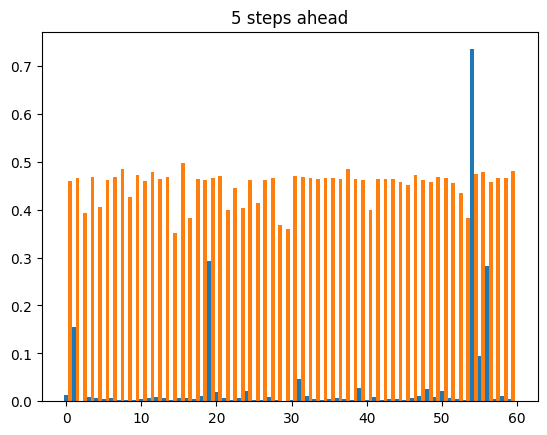

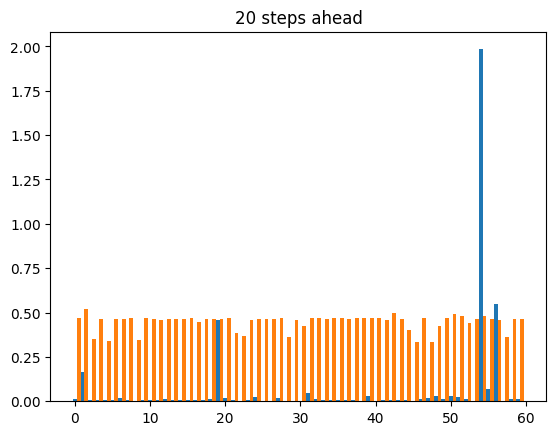

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
bar_width = 0.5
ax.set_title('1 step ahead')
ax.bar(datasets, [x[0] for x in one_step_comparison], bar_width, label="VAR")
ax.bar([x+bar_width for x in datasets], [x[1] for x in one_step_comparison], bar_width, label="CNN")
plt.show()
fig, ax = plt.subplots()
ax.set_title('5 steps ahead')
ax.bar(datasets, [x[0] for x in five_steps_comparison], bar_width, label="VAR")
ax.bar([x+bar_width for x in datasets], [x[1] for x in five_steps_comparison], bar_width, label="CNN")
plt.show()
fig, ax = plt.subplots()
ax.set_title('20 steps ahead')
ax.bar(datasets, [x[0] for x in twenty_steps_comparison], bar_width, label="VAR")
ax.bar([x+bar_width for x in datasets], [x[1] for x in twenty_steps_comparison], bar_width, label="CNN")
plt.show()